### P-curve Mixture Model for population prevalance estimation

In [1]:
# if running from 'examples' directory of p2prev repo, 
# we need to add parent directory to module search path
# so that p2prev module can be imported
# (not necessary if you've pip installed p2prev module)
import sys
import os
cwd = os.getcwd()
pardir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.append(pardir)

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from p2prev import PCurveMixture

In [3]:
pvals = [0.00060, 0.02999, 0.04939, 0.94601]
pvals = np.array(pvals)

# intialize model with observed p-values,
# a prior on the scale of the effect size,
# and any valid arguments to pymc.sample(),
model = PCurveMixture(
    # model arguments:
    pvals, effect_size_prior = 1.5, 
    # sampler arguments:
    draws = 5000, # samples *per chain*, default 5 chains
    target_accept = .95
)

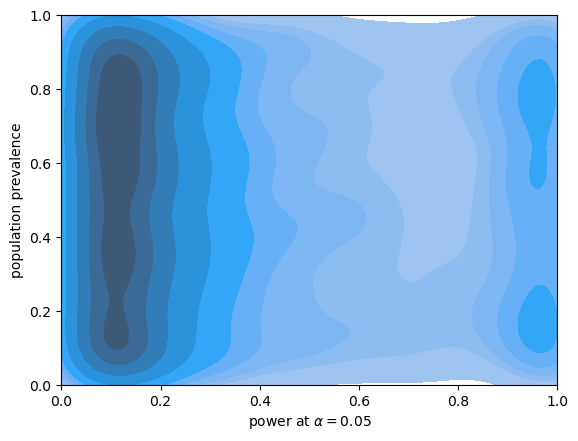

Prior predictive power at 0.05, 90% HDI: [0.05001588 0.96062395]


In [4]:
def plot_power_simulation(pow_df, alpha):
    sns.kdeplot(data = pow_df, x = 'power', y = 'prevalence', fill = True)
    plt.xlabel(r'power at $\alpha = %.02f$'%alpha)
    plt.ylabel('population prevalence')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

alpha = .05
pow_df = model.prior_predictive_power(alpha)
plot_power_simulation(pow_df, alpha)

hdi_prob = .9
hdi = model.prior_predictive_power_hdi(alpha, hdi_prob)
print('Prior predictive power at %.02f, %d%% HDI:'%(alpha, 100*hdi_prob), hdi)

In [5]:
model.fit()
model.summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 5_000 draw iterations (5_000 + 25_000 draws total) took 25 seconds.


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
effect_size,2.035,0.707,0.651,3.321,0.007,0.005,9795.0,5950.0,1.0
prevalence,0.610,0.212,0.224,0.972,0.002,0.001,10243.0,9644.0,1.0


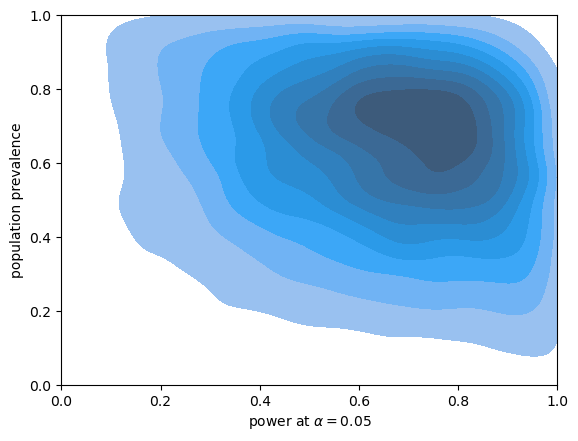

Posterior predictive power at 0.05, 90% HDI: [0.30735886 0.99998957]
Posterior mean: 0.6238466861403433


In [6]:
pow_df = model.posterior_predictive_power(alpha)
plot_power_simulation(pow_df, alpha)
hdi = model.posterior_predictive_power_hdi(alpha, hdi_prob)
print('Posterior predictive power at %.02f, %d%% HDI:'%(alpha, 100*hdi_prob), hdi)
print('Posterior mean:', pow_df.power.mean())

In [7]:
m = model.map
print('Posterior maximum prevalence:', m)

Output()

Posterior maximum prevalence: 0.7100407859788032


In [8]:
# we can also fit alternative (i.e. H1 or H0 only)
# models and apply Bayesian model comparison
model.fit_alternative()
model.compare()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size]


Output()

Sampling 5 chains for 1_000 tune and 5_000 draw iterations (5_000 + 25_000 draws total) took 15 seconds.


Output()

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mixture,0,3.484267,1.694839,0.000000,9.045255e-01,3.167552,0.000000,False,log
all $H_1$,1,0.944284,3.110241,2.539983,3.488701e-16,4.768885,2.261984,False,log
all $H_0$,2,0.000000,0.000000,3.484267,9.547448e-02,0.000000,3.167552,False,log


According the the `arviz` docs, the above weights "can be loosely interpreted as the probability of each model (among the compared model) given the data." But this interpretation may not make sense if you place a high prior probability on one model or another.

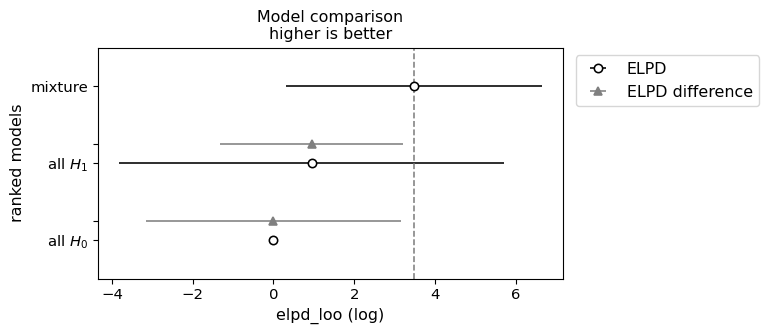

In [9]:
model.plot_compare()
plt.show()

### Binomial Outcome Model 

For comparison, we've implemented the binomial outcome model used by [Ince et al. (2021)](https://doi.org/10.7554/eLife.62461). As can be seen below, its population prevalance estimations can dramatically differ for the exact same data, depending on the arbitrary `alpha` used.

In [10]:
from p2prev._benchmarking import BinomialOutcomesModel
k = (pvals <= alpha).sum()
n = len(pvals)
model = BinomialOutcomesModel(k, n, alpha)
model.fit()
model.summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [prevalence, power]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 6 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
power,0.731,0.187,0.397,0.999,0.003,0.002,3561.0,2367.0,1.0
prevalence,0.721,0.194,0.382,1.000,0.003,0.002,3417.0,2202.0,1.0


In [11]:
m = model.map
print('Posterior maximum:', m)

Output()

Posterior maximum: 0.8624446839260521


In [12]:
lower_alpha = .01
new_k = (pvals <= lower_alpha).sum()
model = BinomialOutcomesModel(new_k, n, lower_alpha)
model.fit()
model.summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [prevalence, power]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 6 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
power,0.516,0.257,0.126,0.997,0.005,0.004,2773.0,2238.0,1.0
prevalence,0.504,0.253,0.114,0.993,0.005,0.004,2548.0,2070.0,1.0


In [13]:
m = model.map
print('Posterior maximum:', m)

Output()

Posterior maximum: 0.49497559499589433


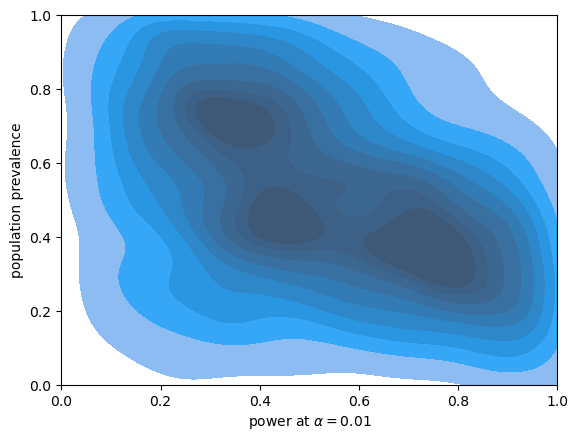

In [14]:
df = pd.DataFrame(dict(
    power = model.power,
    prevalence = model.prevalence
))
plot_power_simulation(df, lower_alpha)

The reason for this dependence, as shown above, is the large inverse correlation between power and prevalence in the posterior. The binomial model can't differentiate between higher-power/lower-prevalence and lower-power/higher-prevalence. 